<a href="https://colab.research.google.com/github/AndreySmirdin/DeepUnsupervisedLearning/blob/hw3/Task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime
import pickle
import os
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
import torchvision
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from tqdm.auto import tqdm
from google.colab import drive

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


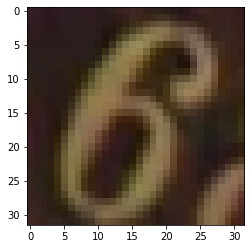

In [0]:
drive.mount('/content/drive')

mnist_path = '/content/drive/My Drive/Colab Notebooks/hw3-q2.pkl'

with open(mnist_path, 'rb') as f:
    dataset = pickle.load(f)

train_data = dataset['train']
test_data = dataset['test']

plt.imshow(train_data[239]);

In [0]:
batch_size = 64
num_epochs = 27
lr = 0.0001

def process_data(data):
    return torch.tensor(data.transpose(0, 3, 1, 2)) / 255.0

train_loader = torch.utils.data.DataLoader(process_data(train_data), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(process_data(test_data), batch_size=batch_size, shuffle=False)

In [0]:
class ResidiulBlock(nn.Module):
     def __init__(self, in_channels):
         super().__init__()
         self.in_channels = in_channels
         self.layers = nn.Sequential(nn.Conv2d(self.in_channels, 64, 3, stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 256, 3, stride=1, padding=1), 
                                     nn.ReLU())
         
     def forward(self, x):
         x = x.float()
         y = self.layers(x)
         return torch.sigmoid(x) * y

class ResidiulStack(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(*[ResidiulBlock(256) for _ in range(5)])

    def forward(self, x):
        return self.layers(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(3, 128, 4, stride=2, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 256, 4, stride=2, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(256, 256, 3, stride=1, padding=1),
                                   ResidiulStack(),
                                   nn.Conv2d(256, 512, 1)
                                   )
        
    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(256, 256, 3, stride=1, padding=1),
                                    ResidiulStack(),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
                                    )
        
    def forward(self, x):
        return self.model(x)

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, X):
        X = X.float()
        n = X.shape[0]
        encoded = self.encoder(X)
        mu, sigma = torch.chunk(encoded, 2, dim=1)

        sampled = torch.randn(mu.shape).to(device) * (sigma.exp() ** 0.5) + mu
        decoded = self.decoder(sampled)
        kl_loss = (sigma.exp() + mu ** 2 - 1 - sigma) / 2
        return decoded, nn.MSELoss()(decoded, X), kl_loss.mean()

    def sample(self, n=100):
        sampled = torch.randn((n, 256, 9, 9)).to(device)
        decoded = self.decoder(sampled)
        return decoded

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/'
state_path = os.path.join(path, 'state.pkl')

def load_model(model, num):
    model.load_state_dict(torch.load(os.path.join(path, f'svhn{num}.data')))
    model.eval()
    return model
               

def train(model, optim, train_loader, test_loader, num_epochs, continue_train=True):
    if continue_train and os.path.exists(state_path):
        with open(state_path, 'rb') as f:
            state_dict = pickle.load(f)
        print(state_dict)
        losses = state_dict['loss']
        val_losses = state_dict['val_losses']
        mse_losses = state_dict['mse']
        kl_losses = state_dict['kl']
        start = state_dict['epoch']
        model = load_model(model, start)
        start += 1
        
    else:
        losses, val_losses = [], []
        mse_losses, kl_losses = [], []
        start = 0

    print(f"Resumed training after {start} epochs")

    
    for epoch in tqdm(range(start, num_epochs)):
        loss, val_loss = 0, 0
        for batch in tqdm(train_loader):
            batch = batch.to(device)
            optim.zero_grad()
            z, mse_loss, kl_loss = model(batch)
            all_loss = mse_loss + kl_loss
            loss += all_loss.item()
            all_loss.backward()
            optim.step()
        
        
        mse, kl = 0, 0
        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                batch = batch.to(device)
                z, mse_loss, kl_loss = model(batch)
                mse += mse_loss.item()
                kl += kl_loss.item()
                val_loss += (mse_loss + kl_loss).item()
                # if i == 0:
                #     
                #     return
                
        loss /= len(train_loader)
        val_loss /= len(test_loader)
        losses.append(loss)
        val_losses.append(val_loss)
        mse_losses.append(mse / len(test_loader))
        kl_losses.append(kl / len(test_loader))

        print(f'After epoch {epoch} train loss is {loss} valiidation loss is {val_loss}')

        with open(state_path, 'wb') as f:
            pickle.dump({
                'loss': losses,
                'val_losses': val_losses,
                'epoch': epoch,
                'mse': mse_losses,
                'kl': kl_losses
            }, f)
        torch.save(model.state_dict(), os.path.join(path, f'svhn{epoch}.data'))
    
    return losses, val_losses

In [0]:
encoder = Encoder()
decoder = Decoder()
model = VAE(encoder, decoder).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
train(model, optim, train_loader, test_loader, num_epochs)

{'loss': [0.031407284581081656, 0.01549158192390556, 0.013798193162384828, 0.012913369248457665, 0.0123698747744847, 0.011806170291707252, 0.01156704763635256, 0.011209989723566086, 0.010802973397834918, 0.010541802916719165, 0.010274698708484638, 0.01014144932146606, 0.009921060770273092, 0.009780371624878837, 0.009660978054954777, 0.009528388725873716, 0.009422944000064893, 0.009349154144485781, 0.009295806519517351, 0.009182726481078493, 0.009111333680885667, 0.009074173914675106, 0.009029028642738362], 'val_losses': [0.01860180158049088, 0.016479340539810407, 0.01667717833264161, 0.013917370989955321, 0.013509527674855559, 0.012773280958725135, 0.012596621157496216, 0.011917188434108762, 0.011430785725813094, 0.011273405276678264, 0.01089270645638136, 0.01052972304129044, 0.010425214098505584, 0.010529664571623545, 0.010109706686841694, 0.010042312223217118, 0.009758097010936944, 0.009767649649511977, 0.009851576555611826, 0.009717671927156188, 0.009784309109970378, 0.0093339149787

After epoch 23 train loss is 0.008967365134167769 valiidation loss is 0.009238388930522912


After epoch 24 train loss is 0.008898480892882372 valiidation loss is 0.009868838221374762


After epoch 25 train loss is 0.008888963331711396 valiidation loss is 0.009298302654259329


After epoch 26 train loss is 0.008767629463214762 valiidation loss is 0.009161704180977268


([0.031407284581081656,
  0.01549158192390556,
  0.013798193162384828,
  0.012913369248457665,
  0.0123698747744847,
  0.011806170291707252,
  0.01156704763635256,
  0.011209989723566086,
  0.010802973397834918,
  0.010541802916719165,
  0.010274698708484638,
  0.01014144932146606,
  0.009921060770273092,
  0.009780371624878837,
  0.009660978054954777,
  0.009528388725873716,
  0.009422944000064893,
  0.009349154144485781,
  0.009295806519517351,
  0.009182726481078493,
  0.009111333680885667,
  0.009074173914675106,
  0.009029028642738362,
  0.008967365134167769,
  0.008898480892882372,
  0.008888963331711396,
  0.008767629463214762],
 [0.01860180158049088,
  0.016479340539810407,
  0.01667717833264161,
  0.013917370989955321,
  0.013509527674855559,
  0.012773280958725135,
  0.012596621157496216,
  0.011917188434108762,
  0.011430785725813094,
  0.011273405276678264,
  0.01089270645638136,
  0.01052972304129044,
  0.010425214098505584,
  0.010529664571623545,
  0.010109706686841694,


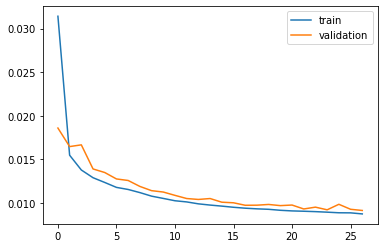

In [0]:
with open(state_path, 'rb') as f:
    state = pickle.load(f)
train_loss = state['loss']
val_loss = state['val_losses']
mse_loss = state['mse']
kl_loss = state['kl']

plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.legend(('train', 'validation'));

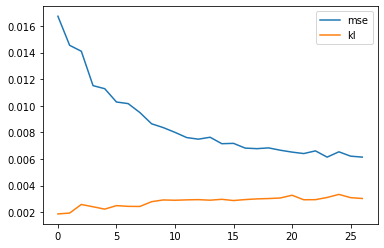

In [0]:
plt.plot(np.arange(len(mse_loss)), mse_loss)
plt.plot(np.arange(len(kl_loss)), kl_loss)
plt.legend(('mse', 'kl'));

Decoded inputs


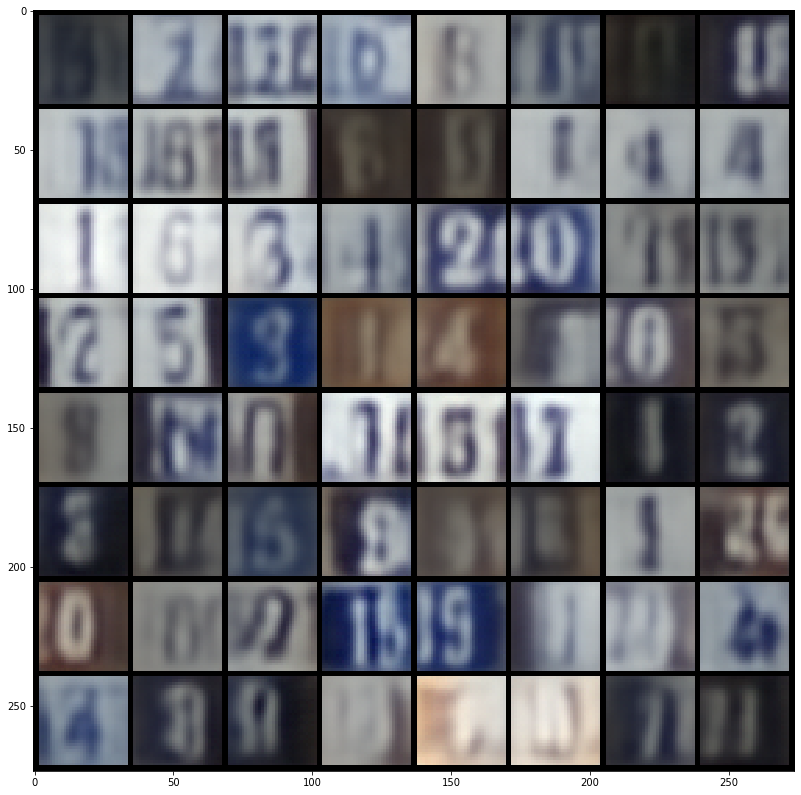

In [0]:
model = load_model(VAE(encoder, decoder), 22)

def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=[14, 14])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("Decoded inputs")
for x in test_loader:
    z, _, _ = model(x.to(device))
    grid = torchvision.utils.make_grid(z.detach(), nrow=8)
    imshow(grid)
    break

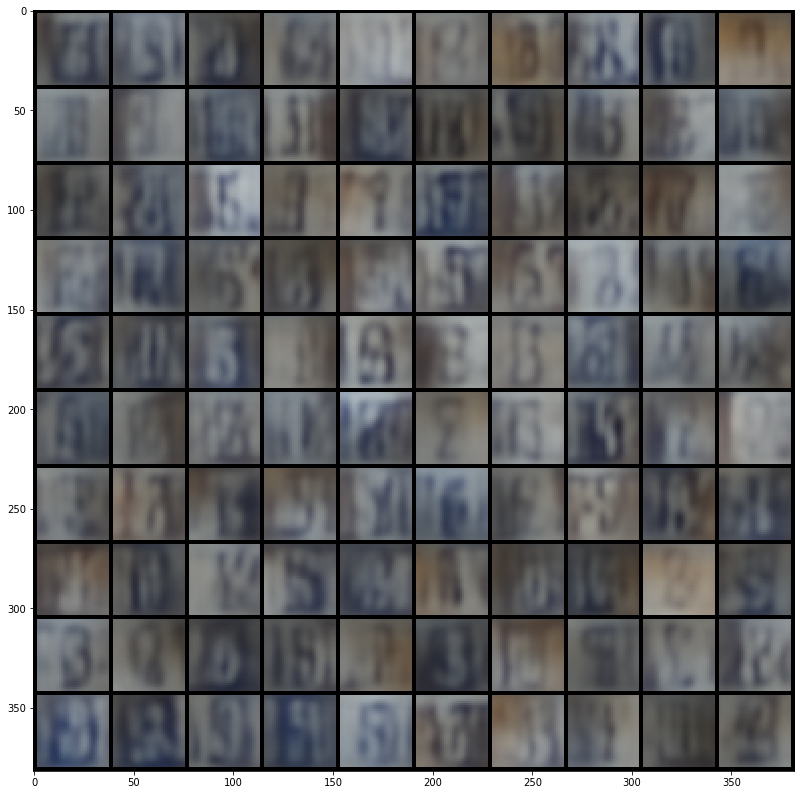

In [0]:
generated = model.sample()
grid = torchvision.utils.make_grid(generated.detach(), nrow=10)
imshow(grid)